In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

## Define growing season length

Growing conditions are defined as daily mean temperatures being 5 degrees Celsius or above. The growing season starts when there has been growing conditions for 7 days for the first time, while it ends after 7 days of non-growing conditions subsequentially. However, calculating the growing season length only based on this can sometimes give unrealistic answers - for example when warm periods in January lead to "start" of the growing season, which then ends during a cold spell in Febuary or March. 

- Version 1: Straigth-forward calculation according to the definition. Can give unrealistically short growing seasons. 

- Version 2: The start of the growing length is the defined as the start of the longest consecutive period between periods of non-growing conditions for 7 days or more. The end is the first period of non-growing conitions after the start. This is not able to account for cases when a cold spell hits after the growing season has started at a realistic time. 

- Version 3: Similar to version 2, this picks out the maximum longest growing season length throughout the year.

- Version 4: The growing season can only end after July 1st. Defintion found here: https://www.climdex.org/learn/indices/#index-GSL 

In [ ]:
def growing_season_length(ds):

    n_lats = len(ds.lat)
    n_lons = len(ds.lon)
    n_years = int(len(ds.time)/365)

    growing_season_length = np.zeros((n_lats, n_lons, n_years))
    temp_threshold = 273.15 + 5 # Temperature threshold for growing
    time_threshold_start = 7 # Time threshold with growing conditions for growing season to start
    time_threshold_end = 7 # Time threshold with non-growing conditions for growing season to end

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                ds1 = ds.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                grow = ds1.values >= temp_threshold # Growing conditions
                non_grow = ds1.values < temp_threshold # Non-growing conditions

                grow_idx = list(np.where(grow)[0]) # Find indexes of different growing conditions
                non_grow_idx = list(np.where(non_grow)[0]) # Find indexes of non-growing conditions

                if not grow_idx:
                    # No growing season
                    length = 0
                elif not non_grow_idx:
                    # Only growing season
                    length = 365
                else:
                    non_grow_idx = np.array(non_grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    grow_idx = np.array(grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    # Find the first day when the differences in days between non-growing conditions is more than time threshold
                    # The start of the growing season is one week after this
                    start_of_GSL = non_grow_idx[np.where(np.diff(non_grow_idx) >= time_threshold_start)]
                    # NB!! Problems with finding start of GSL for some areas
                    start_of_GSL = start_of_GSL[0] + 7
                    print("Start: ", start_of_GSL)
                
                    # Find when the differences between growing conditions indexes is larger than time threshold
                    # Choose the first sufficiently long non-growing period after the growing season start
                    
                    end_of_GSL = grow_idx[np.where(np.diff(grow_idx) >= time_threshold_end)]
                    if np.any(end_of_GSL > start_of_GSL):
                        end_of_GSL = end_of_GSL[np.where(end_of_GSL > start_of_GSL)][0]
                    else:
                        end_of_GSL = 364
                    print("End: ", end_of_GSL)
                    length = end_of_GSL-start_of_GSL + 1 # Add 1 to include the whole growing season period
                
                print("Length: ", length)
                growing_season_length[lat, lon, year] = length
        
    return growing_season_length

In [ ]:
def growing_season_length_v2(ds):

    n_lats = len(ds.lat)
    n_lons = len(ds.lon)
    n_years = int(len(ds.time)/365)

    growing_season_length = np.zeros((n_lats, n_lons, n_years))
    temp_threshold = 273.15 + 5 # Temperature threshold for growing
    time_threshold_start = 7 # Time threshold with growing conditions for growing season to start
    time_threshold_end = 7 # Time threshold with non-growing conditions for growing season to end

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                ds1 = ds.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                grow = ds1.values >= temp_threshold # Growing conditions
                non_grow = ds1.values < temp_threshold # Non-growing conditions

                grow_idx = list(np.where(grow)[0]) # Find indexes of different growing conditions
                non_grow_idx = list(np.where(non_grow)[0]) # Find indexes of non-growing conditions

                if not grow_idx:
                    # No growing season
                    length = 0
                elif not non_grow_idx:
                    # Only growing season
                    length = 365
                else:
                    non_grow_idx = np.array(non_grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    grow_idx = np.array(grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    # Find the days when the differences in days between non-growing conditions is more than time threshold
                    # Choose the day with the maximum difference
                    # The start of the growing season is one week after this
                    start_of_GSL = non_grow_idx[np.where(np.diff(non_grow_idx) >= time_threshold_start)]
                    print(start_of_GSL)
                    if not list(start_of_GSL):
                        length = 0
                    elif len(start_of_GSL) == 1:
                        start_of_GSL = start_of_GSL[0]
                    else:
                        start_of_GSL = start_of_GSL[np.where(np.diff(start_of_GSL) == np.max(np.diff(start_of_GSL)))][0] + 7
                    print("Start: ", start_of_GSL)
                
                    # Find when the differences between growing conditions indexes is larger than time threshold
                    # Choose the first sufficiently long non-growing period after the growing season start
                    
                    end_of_GSL = grow_idx[np.where(np.diff(grow_idx) >= time_threshold_end)]
                    if np.any(end_of_GSL > start_of_GSL):
                        end_of_GSL = end_of_GSL[np.where(end_of_GSL > start_of_GSL)][0]
                    else:
                        end_of_GSL = 364
                    print("End: ", end_of_GSL)
                    length = end_of_GSL-start_of_GSL + 1 # Add 1 to include the whole growing season period
                
                print("Length: ", length)
                growing_season_length[lat, lon, year] = length
        
    return growing_season_length

In [2]:
def growing_season_length_v3(ds):

    n_lats = len(ds.lat)
    n_lons = len(ds.lon)
    n_years = int(len(ds.time)/365)

    growing_season_length = np.zeros((n_lats, n_lons, n_years))
    temp_threshold = 273.15 + 5 # Temperature threshold for growing
    time_threshold_start = 7 # Time threshold with growing conditions for growing season to start
    time_threshold_end = 7 # Time threshold with non-growing conditions for growing season to end

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                ds1 = ds.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                grow = ds1.values >= temp_threshold # Growing conditions
                non_grow = ds1.values < temp_threshold # Non-growing conditions

                grow_idx = list(np.where(grow)[0]) # Find indexes of different growing conditions
                non_grow_idx = list(np.where(non_grow)[0]) # Find indexes of non-growing conditions

                if not grow_idx:
                    # No growing season
                    length = 0
                elif not non_grow_idx:
                    # Only growing season
                    length = 365
                else:
                    non_grow_idx = np.array(non_grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    grow_idx = np.array(grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    # Find the days when the differences in days between non-growing conditions is more than time threshold
                    # Choose the day with the maximum difference
                    # The start of the growing season is one week after this
                    start_of_GSL = non_grow_idx[np.where(np.diff(non_grow_idx) >= time_threshold_start)]
                    print("Start_day: ", start_of_GSL)
                    if not list(start_of_GSL):
                        length = 0
                    else:
                        start_of_GSL = start_of_GSL + 7
                        end_of_GSL = grow_idx[np.where(np.diff(grow_idx) >= time_threshold_end)]
                        print("End days: ",end_of_GSL)
                        if not list(end_of_GSL):
                            length = 365
                        else:
                            growing_periods = []
                            for start_day in start_of_GSL:
                                if np.any(end_of_GSL > start_day):
                                    end_day = end_of_GSL[np.where(end_of_GSL > start_day)][0]
                                else:
                                    end_day = 364
                                growing_periods.append(end_day-start_day+1)

                            length = np.max(growing_periods)
                
                print("Length: ", length)
                growing_season_length[lat, lon, year] = length
        
    return growing_season_length

In [ ]:
def growing_season_length_v4(ds):

    n_lats = len(ds.lat)
    n_lons = len(ds.lon)
    n_years = int(len(ds.time)/365)

    growing_season_length = np.zeros((n_lats, n_lons, n_years))
    temp_threshold = 273.15 + 5 # Temperature threshold for growing
    time_threshold_start = 6 # Time threshold with growing conditions for growing season to start
    time_threshold_end = 6 # Time threshold with non-growing conditions for growing season to end

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                ds1 = ds.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                grow = ds1.values > temp_threshold # Growing conditions
                non_grow = ds1.values < temp_threshold # Non-growing conditions

                grow_idx = list(np.where(grow)[0]) # Find indexes of different growing conditions
                non_grow_idx = list(np.where(non_grow)[0]) # Find indexes of non-growing conditions

                if not grow_idx:
                    # No growing season
                    length = 0
                elif not non_grow_idx:
                    # Only growing season
                    length = 365
                else:
                    non_grow_idx = np.array(non_grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    grow_idx = np.array(grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    # Find the first day when the differences in days between non-growing conditions is more than time threshold
                    # The start of the growing season is one week after this
                    start_of_GSL = non_grow_idx[np.where(np.diff(non_grow_idx) >= time_threshold_start)]
                    # NB!! Problems with finding start of GSL for some areas
                    if not list(start_of_GSL):
                        length = 0
                    else: 
                        start_of_GSL = start_of_GSL[0] + 6
                        print("Start: ", start_of_GSL)
                
                        # Find when the differences between growing conditions indexes is larger than time threshold
                        # Choose the first sufficiently long non-growing period after the growing season start
                    
                        end_of_GSL = grow_idx[np.where(np.diff(grow_idx) >= time_threshold_end)]
                        if np.any(end_of_GSL > 182): # Growing seasons ends first day without growing conditions after July 1st
                            end_of_GSL = end_of_GSL[np.where(end_of_GSL > 182)][0] 
                        else:
                            end_of_GSL = 364
                        print("End: ", end_of_GSL)
                        length = end_of_GSL-start_of_GSL + 1 # Add 1 to include the whole growing season period
                
                print("Length: ", length)
                growing_season_length[lat, lon, year] = length
        
    return growing_season_length

## Load relevant climate variables from CMIP6 data

In [22]:
# Define dataset specifics

model_scenario_name = 'MPI-ESM1-2-LR_ssp245' # Choose a model and SSP scenario
area_name = 'europe' # Choose an area

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'NorESM2-LM_ssp245':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MRI-ESM2-0_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'UKESM1-0-LL_ssp245':
    start_time = '2020-01-01'; end_time = '2059-12-30'
    cooling_year = '2040-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MPI-ESM1-2-LR_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    cooling_year = '2040-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'GFDL-ESM4_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    cooling_year = '2040-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'europe':
    southern_lat = 35; northern_lat = 72
    western_lon = 310; eastern_lon = 33  
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load mean daily temperature data

files = glob.glob(data_folder+'tas_day_'+model_scenario_name+'*')
files.sort()
tas = xr.open_mfdataset(files)

if area_name == 'europe':
    tas1 = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                    lon=slice(western_lon, 360), 
                    time=slice(start_time, end_time))
    tas2 = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                    lon=slice(0, eastern_lon), 
                    time=slice(start_time, end_time))

    temp = xr.concat([tas1, tas2], dim='lon')
else:
    temp = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                    lon=slice(western_lon, eastern_lon), 
                    time=slice(start_time, end_time))

temp.load()

<xarray.DataArray 'tas' (time: 16437, lat: 20, lon: 44)> Size: 58MB
array([[[289.01462, 289.45016, 289.8779 , ..., 282.1533 , 275.70212,
         274.87595],
        [287.14352, 286.70602, 287.84274, ..., 277.3115 , 272.1533 ,
         268.57712],
        [282.16306, 281.58688, 283.3193 , ..., 278.95798, 273.61423,
         269.7939 ],
        ...,
        [248.65915, 244.7529 , 241.7529 , ..., 257.20602, 259.3232 ,
         259.8857 ],
        [246.82516, 244.16501, 241.82907, ..., 262.79   , 258.26657,
         267.02243],
        [243.49118, 241.63766, 239.70016, ..., 270.18454, 270.93454,
         271.72165]],

       [[288.87363, 289.5416 , 289.8619 , ..., 285.43613, 278.58652,
         276.1041 ],
        [286.91464, 286.68027, 287.7252 , ..., 280.80917, 274.817  ,
         269.2994 ],
        [282.36386, 281.97714, 283.317  , ..., 282.4576 , 276.9205 ,
         271.6412 ],
...
        [251.71938, 246.16469, 241.71547, ..., 258.89905, 259.04163,
         257.13342],
        [252.40102, 247.21742, 239.56313, ..., 258.11584, 258.85608,
         266.3717 ],
        [247.88148, 243.40688, 236.78383, ..., 272.44983, 272.2467 ,
         272.151  ]],

       [[291.61026, 291.26456, 290.70987, ..., 288.2997 , 284.12003,
         282.6122 ],
        [292.13565, 291.3134 , 290.09268, ..., 286.81143, 281.8798 ,
         278.3173 ],
        [289.63174, 288.9384 , 288.12784, ..., 288.62198, 284.31534,
         280.5126 ],
        ...,
        [254.01846, 248.6669 , 243.52237, ..., 255.94034, 256.13956,
         255.58487],
        [254.61417, 249.97354, 244.29776, ..., 258.69815, 259.454  ,
         265.92276],
        [251.6669 , 248.41885, 243.83292, ..., 271.63956, 271.7001 ,
         271.83682]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 131kB 2015-01-01T12:00:00 ... 2060-01-01T1...
  * lat      (lat) float64 160B 36.37 38.24 40.1 41.97 ... 68.08 69.95 71.81
  * lon      (lon) float64 352B 311.2 313.1 315.0 316.9 ... 28.12 30.0 31.88
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-05T12:32:19Z altered by CMOR: Treated scalar dime...

In [23]:
# Choose which variable to calculate

variable_name = 'GSL_v4'
unit = 'days'
description = 'Growing season length'
input_values = temp
values = growing_season_length_v4(temp)

# Save data as netcdf file

ds = xr.Dataset(
    data_vars=dict(
        variable=(["lat", "lon", "time"], values)
    ),
    coords=dict(
        lat=input_values[0].lat.values,
        lon=input_values[0].lon.values,
        time=time_array,
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'
ds = ds.rename_vars(dict(variable=variable_name))
ds[variable_name].attrs['units'] = unit
ds[variable_name].attrs['description'] = description

ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
ds

Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365
Length:  365

<xarray.Dataset> Size: 318kB
Dimensions:  (lat: 20, lon: 44, time: 45)
Coordinates:
  * lat      (lat) float64 160B 36.37 38.24 40.1 41.97 ... 68.08 69.95 71.81
  * lon      (lon) float64 352B 311.2 313.1 315.0 316.9 ... 28.12 30.0 31.88
  * time     (time) int64 360B 2015 2016 2017 2018 2019 ... 2056 2057 2058 2059
Data variables:
    GSL_v4   (lat, lon, time) float64 317kB 365.0 365.0 365.0 ... 192.0 299.0

Text(0.5, 1.0, 'Change in growing season length')

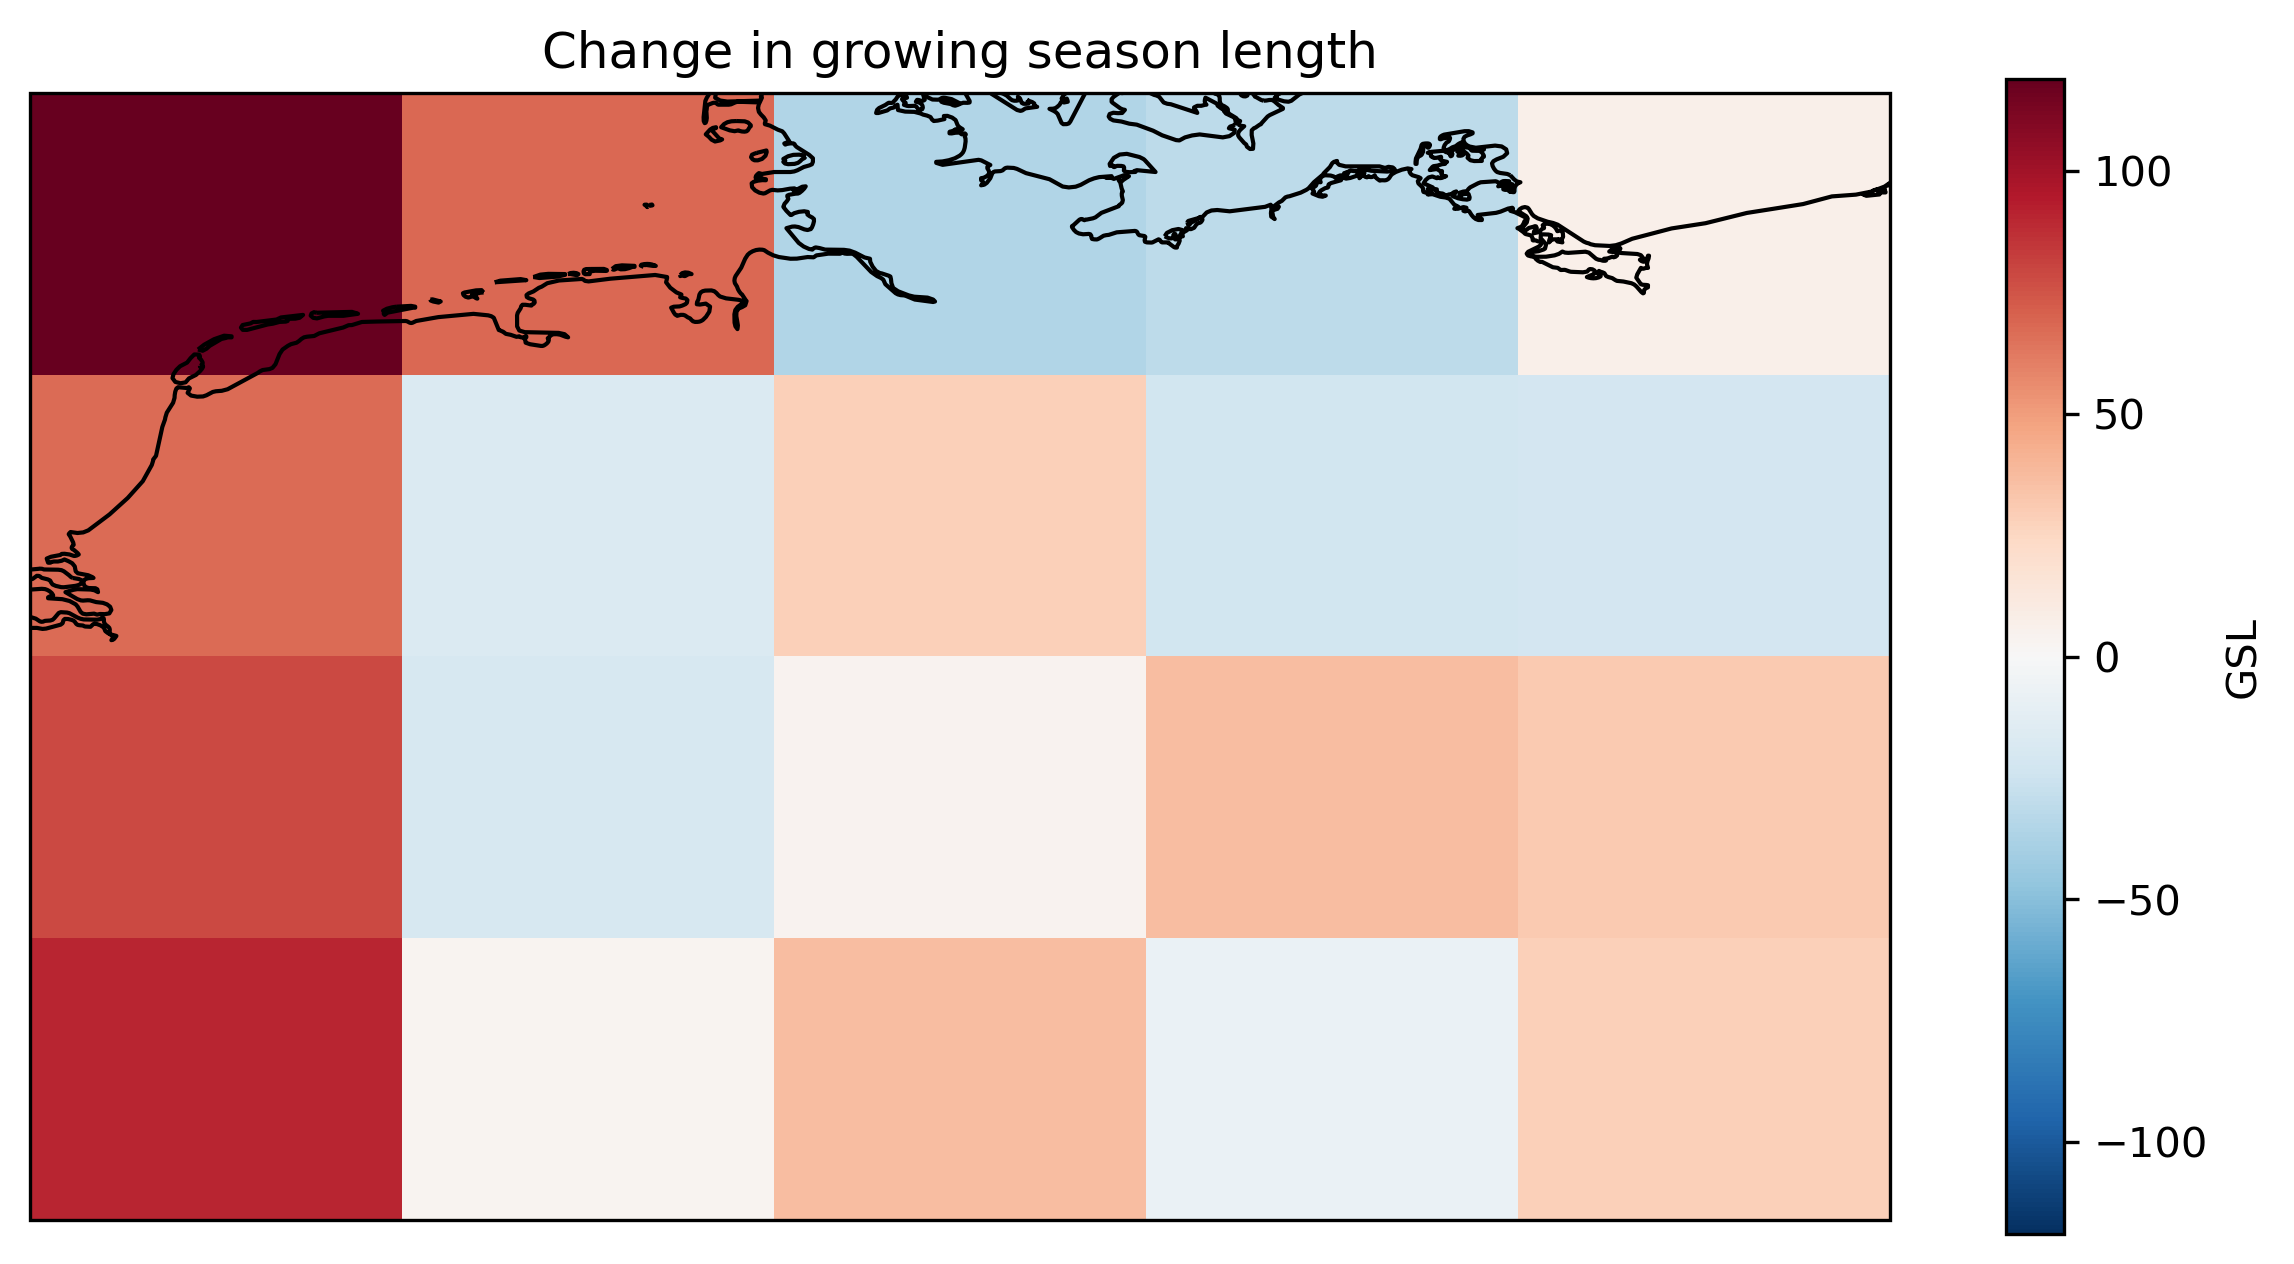

In [ ]:
da = xr.open_dataset(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc', decode_timedelta={variable_name : False})
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = da[variable_name].isel(time=slice(20,40)).mean("time") - da[variable_name].isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in growing season length")